In [1]:
import pandas as pd
import numpy as np
import PIL
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
# Load and preprocess the data
train_dir = './chest_xray/train'
test_dir = './chest_xray/test'
valid_dir = './chest_xray/val'

In [3]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
# Define model creation function
def create_model():
    base_model = tf.keras.applications.ResNet50V2(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )

    for layer in base_model.layers:
        layer.trainable = False

    x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=base_model.input, outputs=output)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [5]:
# K-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True)
fold = 0

for train_index, val_index in kfold.split(train_dir):
    fold += 1
    print(f'Fold: {fold}')

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary',
        subset='training',
        shuffle=True
    )

    valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary'
    )

    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary',
        shuffle=False
    )

Fold: 1
Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Fold: 2
Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Fold: 3
Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Fold: 4
Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Fold: 5
Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [6]:
model = create_model()

In [7]:
# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [8]:
#Train the model
history = model.fit(
        train_generator,
        epochs=30,
        validation_data=valid_generator,
        steps_per_epoch=len(train_generator),
        validation_steps=len(valid_generator)
    )

Epoch 1/30
163/163 [==============================] - 130s 793ms/step - loss: 0.2323 - accuracy: 0.9064 - val_loss: 0.2172 - val_accuracy: 0.9375
Epoch 2/30
163/163 [==============================] - 166s 1s/step - loss: 0.1498 - accuracy: 0.9413 - val_loss: 0.3290 - val_accuracy: 0.9375
Epoch 3/30
163/163 [==============================] - 164s 1s/step - loss: 0.1399 - accuracy: 0.9505 - val_loss: 0.1848 - val_accuracy: 0.9375
Epoch 4/30
163/163 [==============================] - 173s 1s/step - loss: 0.1434 - accuracy: 0.9444 - val_loss: 0.1871 - val_accuracy: 0.9375
Epoch 5/30
163/163 [==============================] - 169s 1s/step - loss: 0.1285 - accuracy: 0.9523 - val_loss: 0.2401 - val_accuracy: 0.9375
Epoch 6/30
163/163 [==============================] - 171s 1s/step - loss: 0.1216 - accuracy: 0.9511 - val_loss: 0.4203 - val_accuracy: 0.9375
Epoch 7/30
163/163 [==============================] - 171s 1s/step - loss: 0.1188 - accuracy: 0.9548 - val_loss: 0.3658 - val_accuracy: 0.8

In [10]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Loss (Fold {fold}):", test_loss)
print(f"Test Accuracy (Fold {fold}):", test_acc)

20/20 [==============================] - 14s 655ms/step - loss: 0.2869 - accuracy: 0.9054
Test Loss (Fold 5): 0.2868618965148926
Test Accuracy (Fold 5): 0.9054487347602844


In [11]:
# Generate predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

20/20 [==============================] - 14s 658ms/step


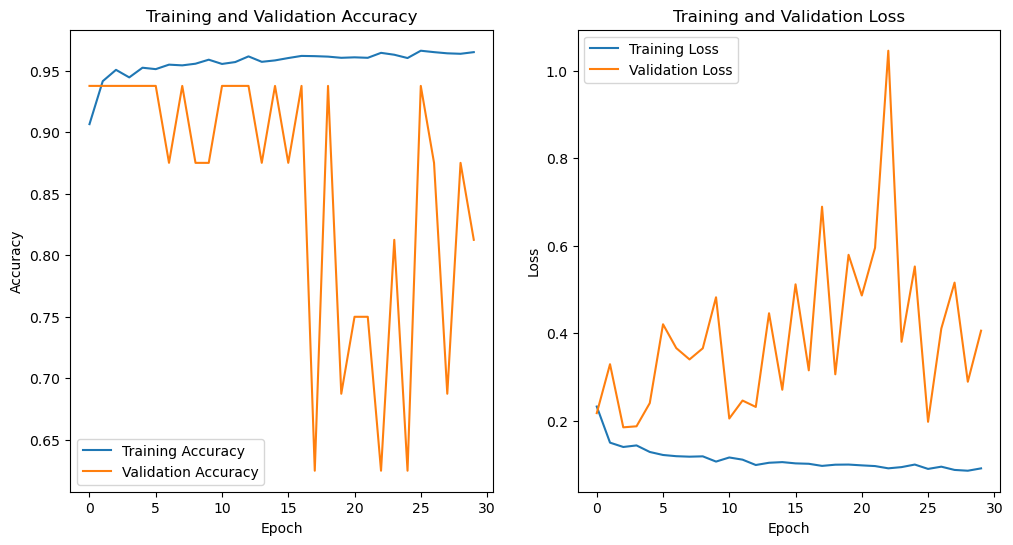

In [15]:
# Plot training and validation accuracy/loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()
    
    

In [18]:
train_scores = model.evaluate(train_generator)
print("Train Loss:", train_scores[0])
print("Train Accuracy:", train_scores[1])

test_scores = model.evaluate(test_generator)
print("\nTest Loss:", test_scores[0])
print("Test Accuracy:", test_scores[1])

163/163 [==============================] - 127s 778ms/step - loss: 0.0813 - accuracy: 0.9678
Train Loss: 0.0812796950340271
Train Accuracy: 0.9677914381027222
20/20 [==============================] - 15s 745ms/step - loss: 0.2869 - accuracy: 0.9054

Test Loss: 0.2868618965148926
Test Accuracy: 0.9054487347602844
